In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams.update({'figure.dpi': 300})

In [3]:
import numpy as np
from scipy.spatial import distance
from scipy.optimize import minimize
from numpy.random import multivariate_normal
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

### Define General Setting

In [4]:
d = 100
N = 10

In [5]:
np.random.seed(1993)  # set seed for repetative results.

### Define Dataset (Woodworth et al.)

In [6]:
s = 5
noise_var = 0.01

X_train = multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=N)
X_test = multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=2000)
w_star = np.zeros(d)
support = np.random.choice(np.arange(d), s, replace=False)
w_star[support] = 1/np.sqrt(s)
y_train = np.dot(X_train, w_star) + np.sqrt(noise_var) * np.random.randn(N)
y_test = np.dot(X_test, w_star)

X_train = torch.DoubleTensor(X_train)
X_test = torch.DoubleTensor(X_test)
y_train = torch.DoubleTensor(y_train)
y_test = torch.DoubleTensor(y_test)

In [7]:
y_train.shape, X_train.shape

(torch.Size([10]), torch.Size([10, 100]))

### Define FC Model

In [8]:
def symmetric_init(alpha, s, m, d, symmetric=True):
    """
    alpha = |a_0| + ||w_0||
    s = (|a_0| - ||w_0||) / (|a_0| + ||w_0||)
    """
    norms_w = []
    norms_a = []
    for alpha_i, s_i in zip(alpha, s):
        norm_w = np.sqrt(alpha_i * (1 - s_i) / (1 + s_i))
        norm_a = np.sqrt(alpha_i * (1 + s_i) / (1 - s_i))
        norms_w.append(norm_w)
        norms_a.append(norm_a)

    w_0 = np.random.normal(size=(m, d), loc=0, scale=1)
    w_0_norms = np.linalg.norm(w_0, axis=1, ord=2)
    w_0 = w_0 / w_0_norms[:, np.newaxis] * np.array(norms_w)[:, np.newaxis]

    a_0 = np.random.normal(size=(1, m), loc=0, scale=1)
    a_0 = np.multiply(np.ones_like(a_0) * np.array(norms_a), (1 * (a_0 > 0) - 0.5) * 2)

    if symmetric:
        w_0[m // 2:, :] = w_0[:m // 2, :]
        a_0[:, m // 2:] = -a_0[:, :m // 2]

    return w_0.transpose(), a_0.reshape(-1,)

In [162]:
class TwoLayerModel(nn.Module):
    def __init__(self, alpha, s, m, d, use_relu=False, symmetric=True):
        super(TwoLayerModel, self).__init__()

        self.w = nn.Parameter(torch.DoubleTensor(d, m))
        self.a = nn.Parameter(torch.DoubleTensor(m))

        if use_relu:
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()

        with torch.no_grad():
            # unbiased init
            w_0, a_0 = symmetric_init(alpha, s, m, d, symmetric=symmetric)
            self.w.data, self.a.data = torch.DoubleTensor(w_0), torch.DoubleTensor(a_0)
            self._w_0 = self.w.transpose(1, 0).clone().detach().numpy()
            self._a_0 = self.a.view(-1, 1).clone().detach().numpy()

    def forward(self, x):
        x = torch.matmul(x, self.w)
        x = self.activation(x)
        x = torch.mv(x, self.a)
        return x
    
    @property
    def current_w(self):
        return self.w.transpose(1, 0).detach().numpy()
    
    @property
    def current_a(self):
        return self.a.view(-1, 1).detach().numpy()

    @property
    def w_0(self):
        return self._w_0

    @property
    def a_0(self):
        return self._a_0
    
    
def train(alpha, s, m, d, step_size, use_relu=False, symmetric=True, early_stop_tol=1e-5, num_epochs=int(1e7)):
    model = TwoLayerModel(alpha=alpha, s=s, m=m, d=d, use_relu=use_relu, symmetric=symmetric)
    optimizer = torch.optim.SGD(model.parameters(), lr=step_size)

    w_tilde_array = []
    w_tilde_array.append(model.current_w * model.current_a)  # get the initial state
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred = model(X_train)
        loss = F.mse_loss(pred, y_train)
        loss.backward()
        optimizer.step()

        w_tilde_array.append(model.current_w * model.current_a)
        if loss.item() < early_stop_tol:
            print(f'early stopping after {epoch + 1} epochs')
            break

    with torch.no_grad():
        test_loss = F.mse_loss(model(X_test), y_test)
    return model, loss, test_loss, w_tilde_array

### Define Q Function

$q\left(\mathbf{\tilde{w}}(t)\right)=\frac{\left(\left\Vert \mathbf{\tilde{w}}(t)\right\Vert ^{2}-\frac{\delta}{2}\left(\frac{\delta}{2}+\sqrt{\left\Vert \mathbf{\tilde{w}}(t)\right\Vert ^{2}+\frac{\delta^{2}}{4}}\right)\right)\sqrt{\sqrt{\left\Vert \mathbf{\tilde{w}}(t)\right\Vert ^{2}+\frac{\delta^{2}}{4}}-\frac{\delta}{2}}}{\left\Vert \mathbf{\tilde{w}}(t)\right\Vert }-\frac{3}{2}\sqrt{\sqrt{\left\Vert \mathbf{\tilde{w}}(0)\right\Vert ^{2}+\frac{\delta^{2}}{4}}-\frac{\delta}{2}}\frac{\mathbf{\tilde{w}}^{\top}(0)}{\left\Vert \mathbf{\tilde{w}}(0)\right\Vert }\mathbf{\tilde{w}}(t)$

In [163]:
def q(w_i, w_i_0, delta_i):
    d = delta_i/2
    norm_w_i = np.linalg.norm(w_i, ord=2)
    norm_w_i_0 = np.linalg.norm(w_i_0, ord=2)
    
    return (1/norm_w_i) * (norm_w_i**2 - d * (d + np.sqrt(norm_w_i**2 + d**2))) * np.sqrt(np.sqrt(norm_w_i**2 + d**2) - d)\
        - (3/2) * np.sqrt(np.sqrt(norm_w_i_0**2 + d**2) - d) * np.matmul(w_i_0.transpose(), w_i) / norm_w_i_0

In [164]:
def Q(w, w_0, delta):
    f = 0
    for w_i, w_i_0, delta_i in zip(w, w_0, delta):
        f += q(w_i, w_i_0, delta_i)
    return f

In [165]:
def flatten(w, a):
    return np.hstack([w.copy().flatten(), a.copy().flatten()])

def restore(v, m, d):
    w = v.copy()[: m * d].reshape(m, d)
    a = v.copy()[m * d:].reshape(m, 1)
    return w, a

In [166]:
def constraint(v, x, y, m, d):
    w, a = restore(v, m, d)
    w_tilde = w * a
    return (np.matmul(w_tilde, x.transpose()).sum(axis=0) - y).squeeze()

def constraint_relu(v, x, y, m, d):
    w, a = restore(v, m, d)
    y_pred = (np.maximum(np.matmul(w, x.transpose()), 0) * a).sum(axis=0)
    return (y_pred - y).squeeze()

def solver(x, y, w_0, a_0, alpha, s, obj='L1', optim_tol=1e-5, use_relu=False):
    x0 = flatten(w_0, a_0)

    if use_relu:
        cons = {'type': 'eq', 'fun': lambda v: constraint_relu(v, x, y, m, d)}
    else:
        cons = {'type': 'eq', 'fun': lambda v: constraint(v, x, y, m, d)}

    if obj == 'L1':
        objective = lambda v: np.linalg.norm(v, ord=2)
    elif obj == 'Q':
        delta = [4 * alpha_i * s_i / (1 - s_i**2) for alpha_i, s_i in zip(alpha, s)]
        w_tilde_0 = w_0 * a_0
        objective = lambda v: Q(restore(v, m, d)[0] * restore(v, m, d)[1] , w_tilde_0, delta)
    else:
        raise ValueError('objective not supported.')

    sol = minimize(
        fun=objective,
        x0=x0,
        constraints=cons,
        tol=optim_tol,
        method='SLSQP',
        options={
            'maxiter': 100000,
            'disp': False
        }
    )
    is_failed = (not sol.success)
    if is_failed:
        raise RuntimeError('Minimization Failed.')

    return restore(sol.x, m, d)

## Sanity Check (Linear Single Neuron)

In [167]:
m = 1
alpha = [0.1] * m
s = [0.5] * m

In [168]:
model, train_loss, test_loss, w_tilde_array = train(
    alpha=alpha,
    s=s,
    m=m,
    d=d,
    step_size=1e-3,
    symmetric=False,
    early_stop_tol=1e-10)
train_loss.item(), test_loss.item()

early stopping after 2273 epochs


(9.985585707999581e-11, 0.901074347467081)

In [169]:
# sanity check that GD learns
distance.cosine((model.w_0 *  model.a_0).flatten(), (model.current_w * model.current_a).flatten())

0.5453778359456201

In [170]:
w_Q, a_Q = solver(X_train.numpy(), y_train.numpy(), model.w_0, model.a_0, alpha=alpha, s=s, obj='Q')
w_tilde_Q = w_Q * a_Q

In [171]:
distance.cosine(w_tilde_Q.flatten(), w_tilde_array[-1].flatten())

1.0195266075818665e-08

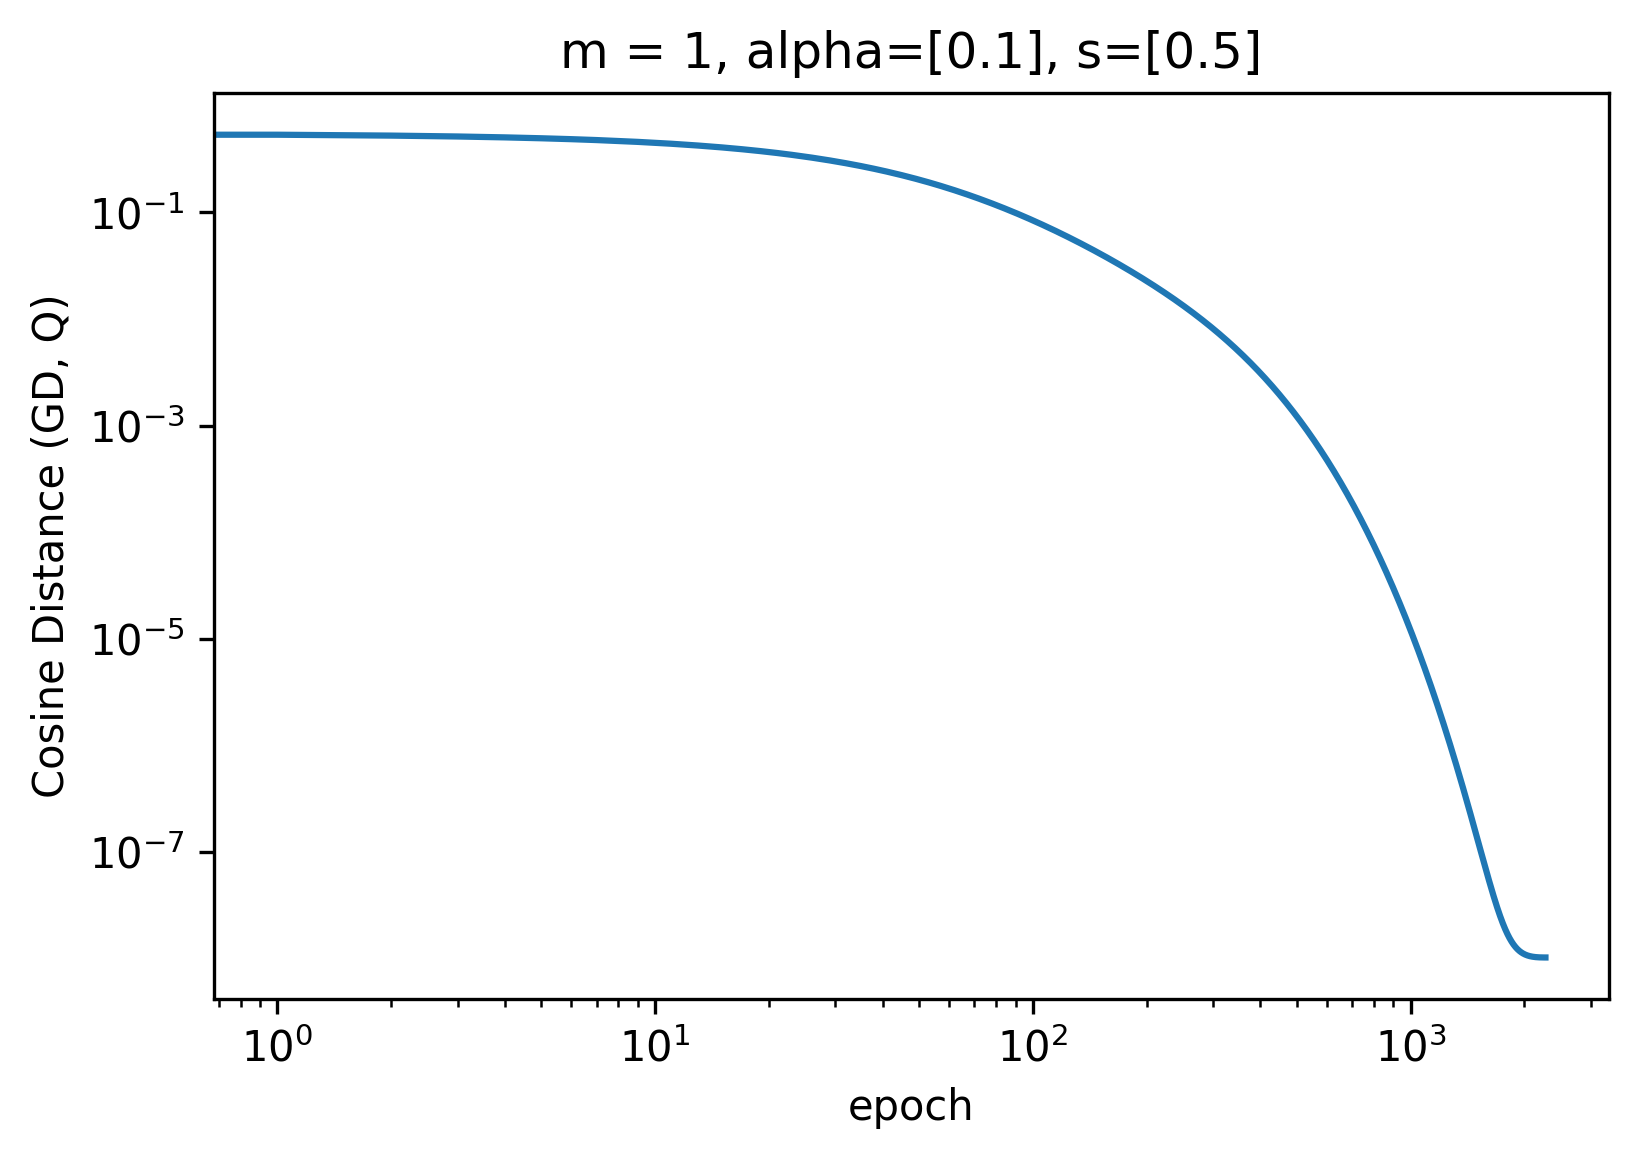

In [172]:
plot([distance.cosine(w_tilde.flatten(), w_tilde_Q.flatten())
         for w_tilde in w_tilde_array])

title(f'm = {m}, alpha={alpha}, s={s}')
ylabel('Cosine Distance (GD, Q)')
xlabel('epoch')
xscale('log')
yscale('log')

## Linear Multi Neuron

In [192]:
m = 3
alpha = [0.01] * m
s = [0.5] * m

In [193]:
model, train_loss, test_loss, w_tilde_array = train(
    alpha=alpha, 
    s=s, 
    m=m, 
    d=d, 
    step_size=1e-3, 
    symmetric=False,
    early_stop_tol=1e-10
)
train_loss.item(), test_loss.item()

early stopping after 3432 epochs


(9.951406702441399e-11, 0.9020451353889175)

In [194]:
# sanity check that GD learns
distance.cosine((model.w_0 *  model.a_0).flatten(), (model.current_w * model.current_a).flatten())

0.8025120731041034

In [195]:
w_Q, a_Q = solver(X_train.numpy(), y_train.numpy(), model.w_0, model.a_0, alpha=alpha, s=s, obj='Q', optim_tol=1e-7)
w_tilde_Q = w_Q * a_Q

In [196]:
distance.cosine(w_tilde_Q.flatten(), w_tilde_array[-1].flatten())

0.0004785337037847004

(1e-05, 1)

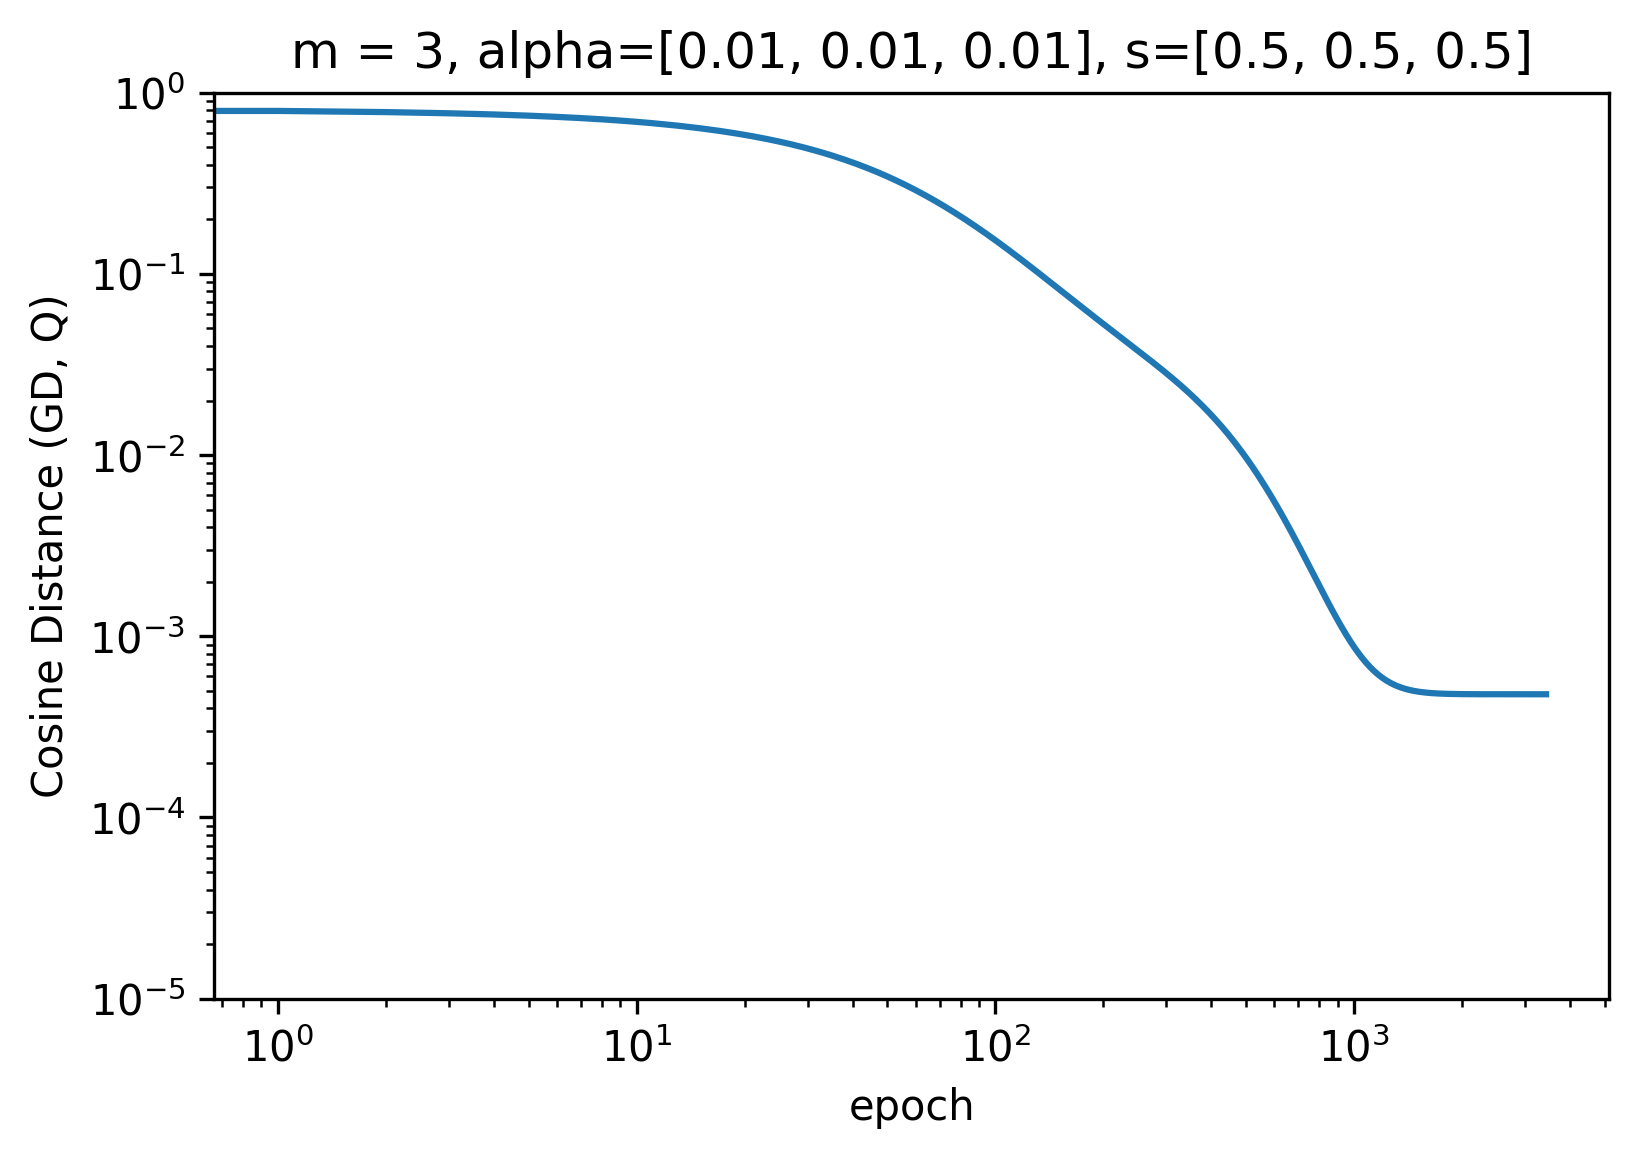

In [197]:
plot([distance.cosine(w_tilde.flatten(), w_tilde_Q.flatten())
         for w_tilde in w_tilde_array])

title(f'm = {m}, alpha={alpha}, s={s}')
ylabel('Cosine Distance (GD, Q)')
xlabel('epoch')
xscale('log')
yscale('log')
ylim([1e-5, 1])

##  Linear Multi Network [with different shapes]

In [181]:
m = 3
alpha = [0.01] * m
s = [0, 0.5, 0.9]

In [183]:
model, train_loss, test_loss, w_tilde_array = train(
    alpha=alpha, 
    s=s, 
    m=m, 
    d=d, 
    step_size=1e-4, 
    symmetric=False,
    early_stop_tol=1e-10
)
train_loss.item(), test_loss.item()

early stopping after 25384 epochs


(9.998111414084418e-11, 0.9092246120219163)

In [184]:
# sanity check that GD learns
distance.cosine((model.w_0 *  model.a_0).flatten(), (model.current_w * model.current_a).flatten())

0.9346435695245663

In [185]:
w_Q, a_Q = solver(X_train.numpy(), y_train.numpy(), model.w_0, model.a_0, alpha=alpha, s=s, obj='Q', optim_tol=1e-10)
w_tilde_Q = w_Q * a_Q

In [186]:
y_pred_Q = (np.matmul(w_Q * a_Q, X_train.numpy().transpose())).sum(axis=0)
loss_Q = F.mse_loss(torch.DoubleTensor(y_pred_Q), y_train)
loss_Q.item()

1.085941578818992e-22

In [187]:
distance.cosine(w_tilde_Q.flatten(), w_tilde_array[-1].flatten())

0.12778196160874644

(1e-05, 1)

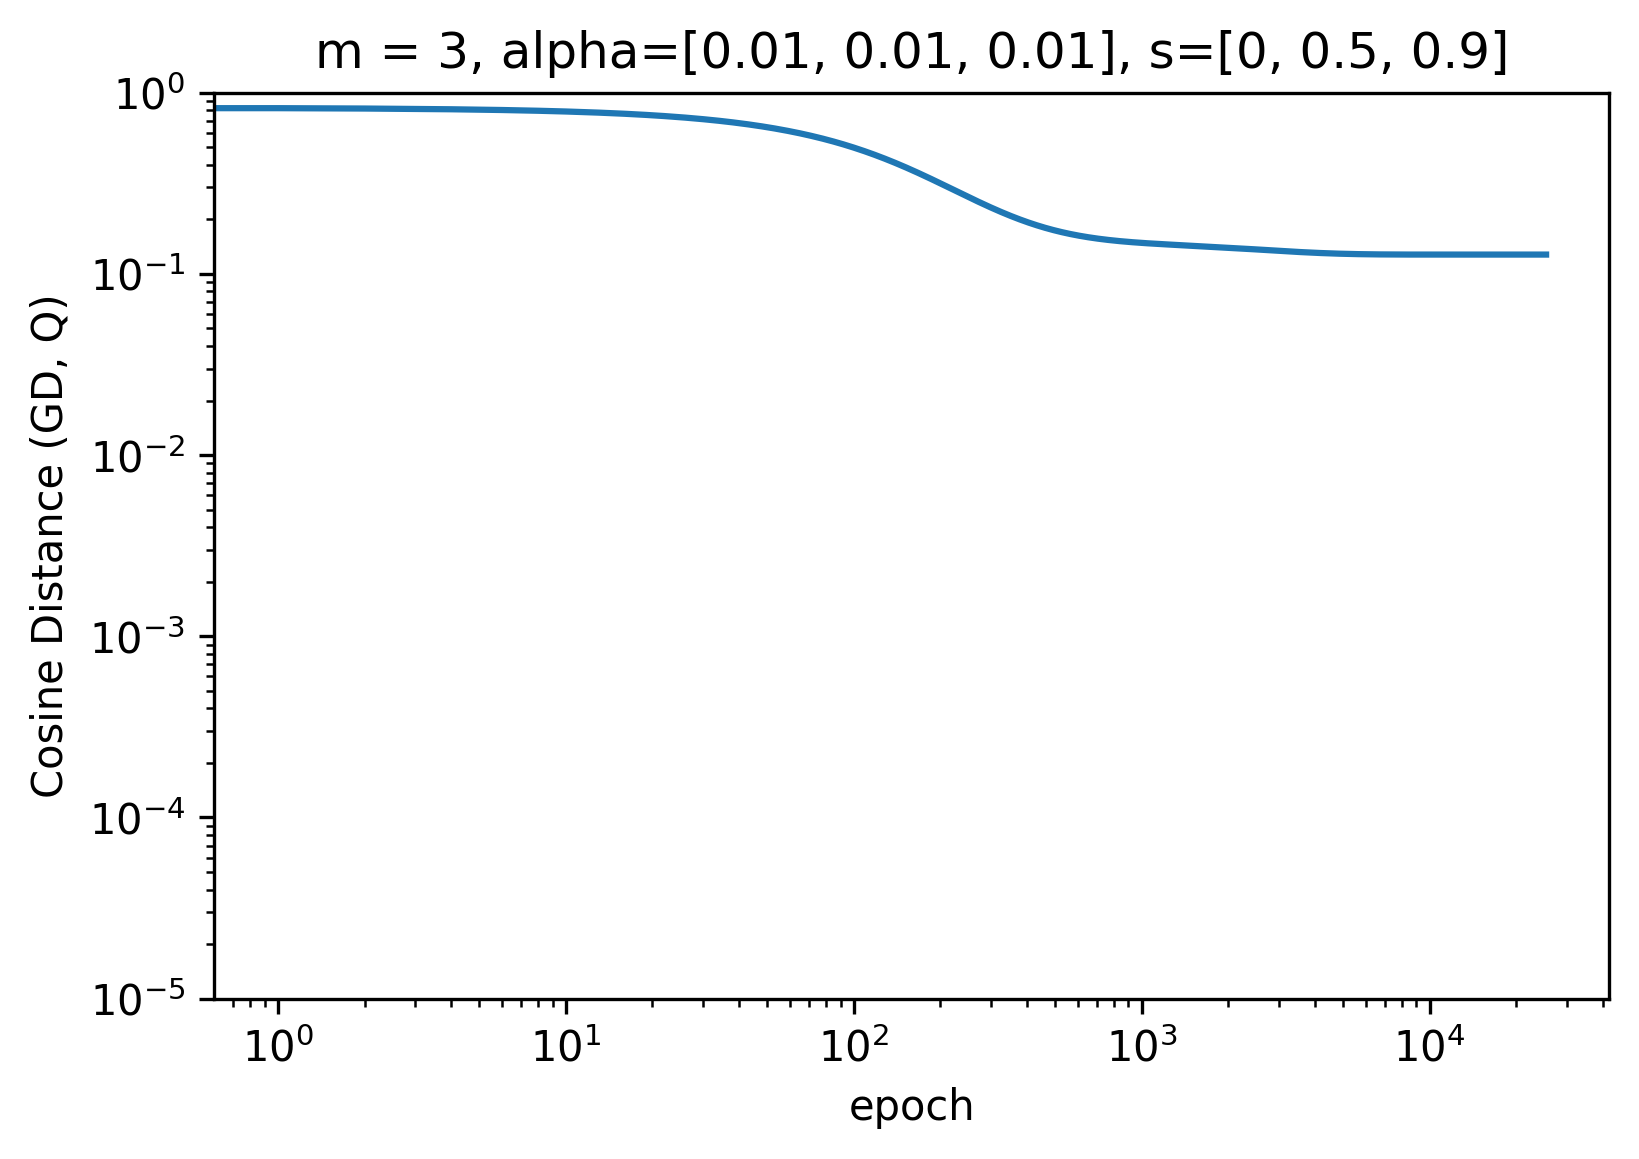

In [190]:
plot([distance.cosine(w_tilde.flatten(), w_tilde_Q.flatten())
         for w_tilde in w_tilde_array])

title(f'm = {m}, alpha={alpha}, s={s}')
ylabel('Cosine Distance (GD, Q)')
xlabel('epoch')
xscale('log')
yscale('log')
ylim([1e-5, 1])

## Non-Linear

In [382]:
d = 5
N = 5

In [383]:
m = 10
alpha = 1
s = 0.5

### Define dataset based on teacher network

In [416]:
teacher = TwoLayerModel(alpha=alpha, s=0.3, m=m, d=d, use_relu=True, symmetric=False)

In [417]:
X_train = torch.DoubleTensor(np.random.normal(size=(N, d), scale=1))
y_train = teacher(X_train).detach()

X_train.shape, y_train.shape

(torch.Size([5, 5]), torch.Size([5]))

In [418]:
y_train

tensor([0.0183, 0.9858, 0.6131, 3.7395, 4.8489], dtype=torch.float64)

In [419]:
def train(alpha, s, m, d, step_size, use_relu=False, symmetric=True, early_stop_tol=1e-5, num_epochs=int(1e7)):
    model = TwoLayerModel(alpha=alpha, s=s, m=m, d=d, use_relu=use_relu, symmetric=symmetric)
    optimizer = torch.optim.SGD(model.parameters(), lr=step_size)

    w_tilde_array = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred = model(X_train)
        loss = F.mse_loss(pred, y_train)
        loss.backward()
        optimizer.step()

        w_tilde_array.append(model.current_w * model.current_a)
        if loss.item() < early_stop_tol:
            print(f'early stopping after {epoch + 1} epochs')
            break

    return model, loss, test_loss, w_tilde_array

In [420]:
model, train_loss, test_loss, w_tilde_array = train(
    alpha=alpha,
    s=s, 
    m=m, 
    d=d, 
    step_size=1e-3,
    symmetric=False,
    early_stop_tol=1e-20,
    use_relu=True)
train_loss.item(), test_loss.item()

early stopping after 12089 epochs


(9.976091363500525e-21, 0.9031829192347001)

In [421]:
# sanity check that GD learns
distance.cosine((model.w_0 *  model.a_0).flatten(), (model.current_w * model.current_a).flatten())

0.06625387972583263

In [422]:
w_Q, a_Q = solver(
    X_train.numpy(),
    y_train.numpy(),
    model.w_0,
    model.a_0,
    alpha=alpha,
    s=s, 
    obj='Q',
    use_relu=True,
    optim_tol=1e-7
)
w_tilde_Q = w_Q * a_Q

In [423]:
y_pred_Q = (np.maximum(np.matmul(w_Q, X_train.numpy().transpose()), 0) * a_Q).sum(axis=0)
loss_Q = F.mse_loss(torch.DoubleTensor(y_pred_Q), y_train)
loss_Q.item()

1.7278666917100321e-15

In [424]:
distance.cosine(w_tilde_Q.flatten(), w_tilde_array[-1].flatten())

0.0003588363961891661

In [425]:
# distance to teacher
distance.cosine((teacher.current_w *  teacher.current_a).flatten(), (model.current_w * model.current_a).flatten())

0.8720508423983806

In [426]:
distance.cosine((teacher.w_0 *  teacher.a_0).flatten(), (w_Q * a_Q).flatten())

0.8742812642317814

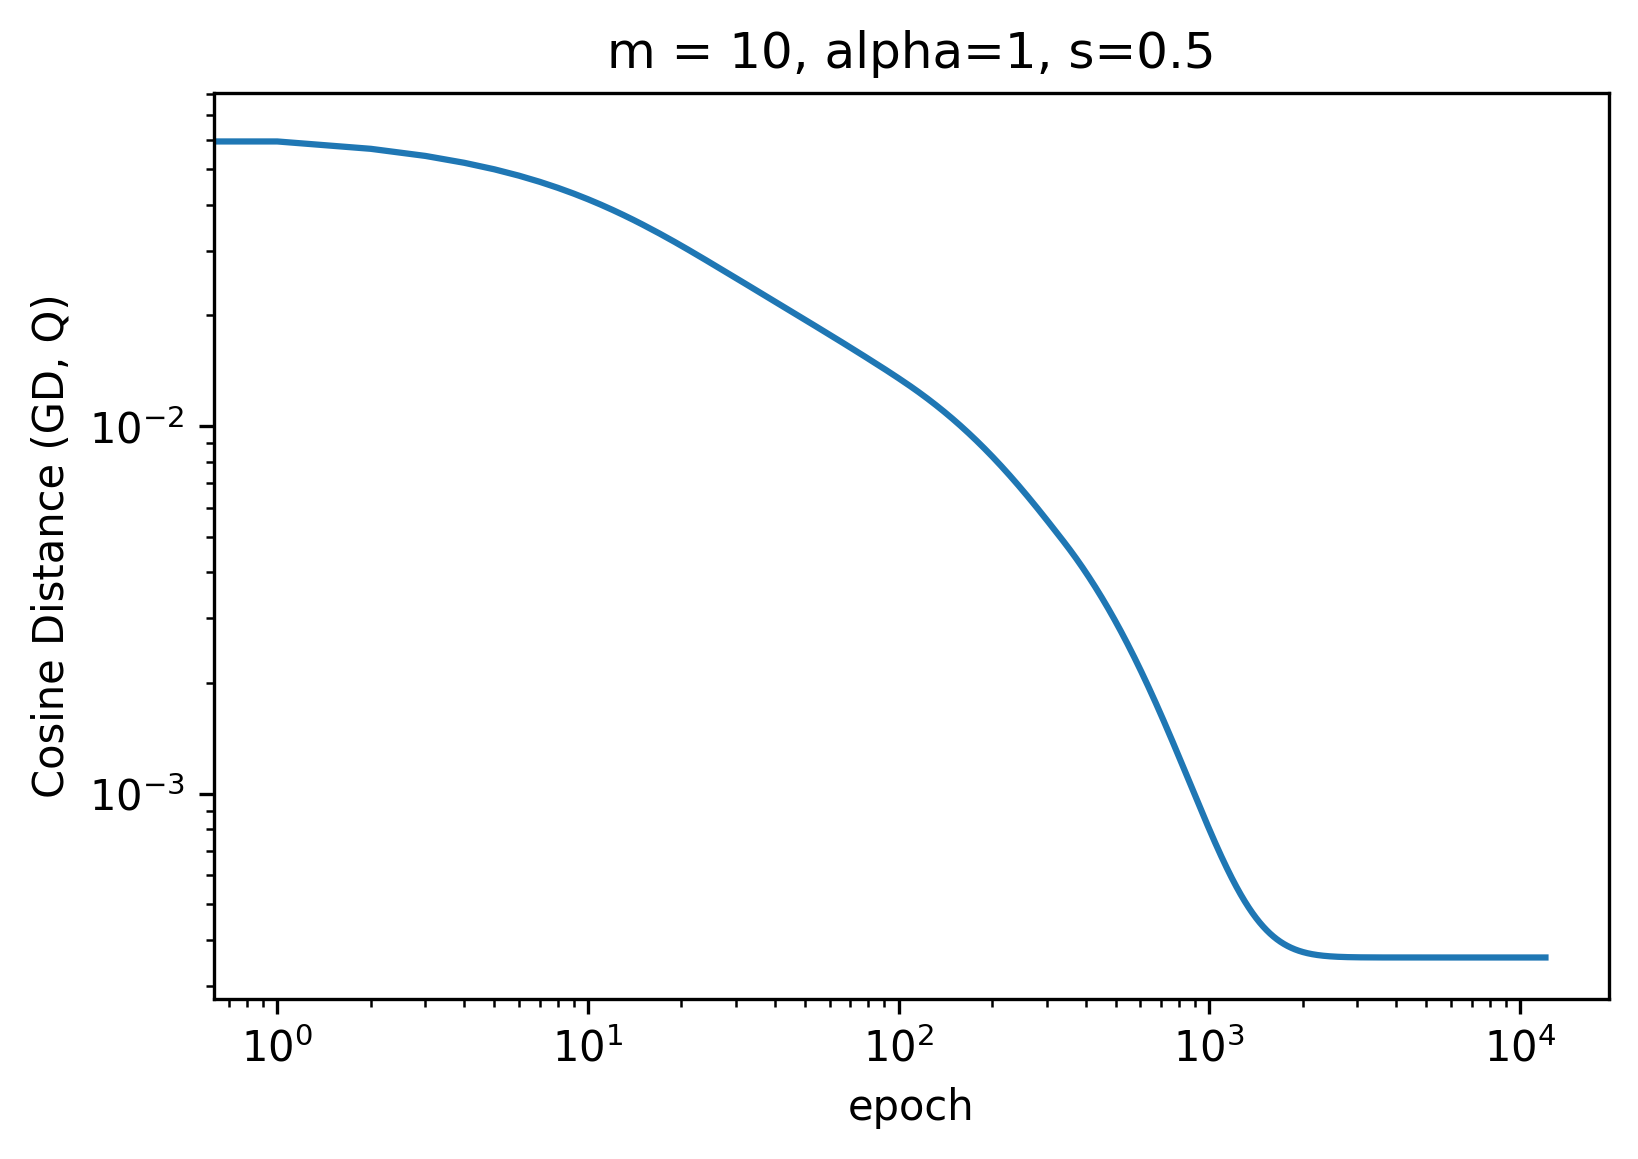

In [427]:
plot([distance.cosine(w_tilde.flatten(), w_tilde_Q.flatten())
         for w_tilde in w_tilde_array])

title(f'm = {m}, alpha={alpha}, s={s}')
ylabel('Cosine Distance (GD, Q)')
xlabel('epoch')
xscale('log')
yscale('log')

### Activation Pattern Analysis

In [428]:
c_i_0 = np.matmul(model.w_0, X_train.numpy().transpose()) > 0 
c_i_current = np.matmul(model.current_w, X_train.numpy().transpose()) > 0 
c_i_teacher = c_i_teacher = np.matmul(teacher.current_w, X_train.numpy().transpose()) > 0 
c_i_Q = np.matmul(w_Q, X_train.numpy().transpose()) > 0 

In [429]:
sum(c_i_current == c_i_0) / (m * N)

0.82

In [430]:
sum(c_i_current == c_i_teacher) / (m * N)

0.54

In [431]:
sum(c_i_current == c_i_Q) / (m * N)

0.94